In [1]:
import cegpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib_inline.backend_inline
import bnlearn as bn
import networkx as nx
from IPython.display import Image

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
sns.set_palette('Set3')
colours = [mpl.colors.to_hex(c) for c in plt.cm.Set3.colors]


def display_graph(g, nodesep=0.005, ranksep=3):
    """
    Displays a dot graph
    """
    g.set('nodesep', nodesep)
    g.set('ranksep', ranksep)
    return Image(g.create_png(), width=1000)

def fit_and_plot_bn(df, columns):
    """
    Fits and plots a Bayesian Network,
    with constrained set of allowed edges.
    """
    model = bn.structure_learning.fit(
        df[columns], 
        scoretype='bic', 
       bw_list_method='edges',
       black_list = [
           ('acc_inv', 'age_group'), 
           ('acc_inv', 'mileage'),
           ('acc_inv', 'freq'),
           ('sex', 'age_group'),
           ('freq', 'age_group'),
           ('is_missing', 'age_group'),
           ('is_missing', 'sex'),
       ]
    )
    G = nx.DiGraph(model['model_edges'])
    fig, ax = plt.subplots(figsize=(7, 7))
    nx.draw_circular(
        G, node_color='C2', node_size=2000, 
        alpha=0.5, linewidths=5, width=2
    )
    nx.draw_networkx_labels(G, pos=nx.circular_layout(G))
    plt.show()

# Chain Event Graphs
## - modelling road accidents of new drivers in the presence of missing data

## The data set

- 'Cohort II' - a six-year study by the Biritish Department for Transport between 2001 and 2005
- Objective: To study how ‘cohorts’ of learner drivers in Great Britain undertook driver training and testing, and their subsequent experiences as new drivers.
- Sample size varies from over 10,000 (DEQ1) to just fewer than 3,000 (DEQ4)
- Consisted of multiple questionnaires sent before the driving test and 6, 12, 24 and 36 months after passing the test.
- Imbalanced proportion of female (62.5%) to male repondents (37.5%) in the initial survey. Proportion of men to women decreased even further in the subseqeuent surveys.



<center><img src="img/flowchart.png" width="500"/></center>

## Plan for the workshops
- **Part 1: Sex, age, frequency, mileage and the accident involvement**
- **Part 2: Dealing with missing data**
- **Part 3: Modelling non-response with CEGs**

## Part 1: Sex, age, frequency / mileage and the accident involvement

In this part of the analysis we take into consideration responses from the first iteration of the DEQ questionnaire only, i.e. the survey sent up to 6 months after passing the driving test. Our variables are:
- $X_{age}$ - the age of the driver when taking the test (16-81)
- $X_{sex}$ - the sex of the driver (female / male)
- $X_{freq}$ - the frequency of driving during the first 6 months after passing the driving test (1 = Everyday, 2 = 4-6 days per week, 3 = Between once a week to to once a fortnight. )
- $X_{miles}$ - self-reported estimated miles driven in the past 6 months.
- $Y$ - binary variable indicating whether an individual reported at least one non low-speed accident during the first 6 months after passing the test. (0/1+)

In [2]:
df = pd.read_csv('data/base_mod.csv', index_col=0)
df.head()

,age,sex,freq,miles,acc_inv
1,19.82,M,2,1200.0,0
2,34.00,F,1,1800.0,0
3,37.71,M,1,4000.0,0
4,44.49,F,1,8000.0,0
5,32.23,F,3,4000.0,0


### Data Preprocessing

Chain Event Graphs are suited for categorical variables. In the original data, the age and the miles driven are continuous. We first apply a crude way of categorising the data by binning them into bins of roughly equal size.

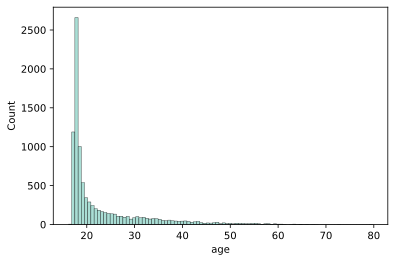

0.33    17.937
0.66    21.500
Name: age, dtype: float64

In [3]:
# bin age and miles

sns.histplot(df['age'])
plt.show()
df['age'].quantile([0.33, 0.66])

In [4]:
df['age_group'] = pd.cut(df['age'], bins=[16, 18, 21, 80])

0.33    2000.0
0.66    6000.0
Name: miles, dtype: float64

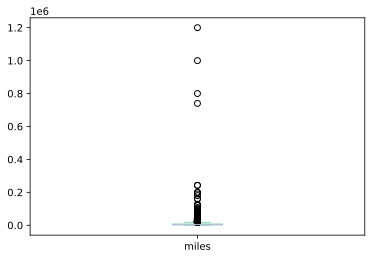

In [5]:
df['miles'].plot(kind='box')
df['miles'].quantile([0.33, 0.66])

In [6]:
df['mileage'] = pd.cut(df['miles'], [0, 2000, 6000, df.miles.max()])
df['mileage'] = df['mileage'].cat.rename_categories(['low', 'average', 'high'])

### Learning the structure of a Bayesian Network

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Filter edges based on black_list/white_list


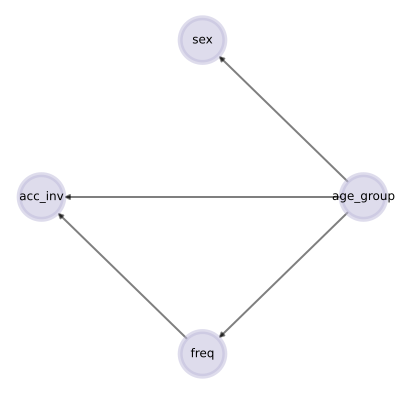

In [7]:
fit_and_plot_bn(df, ['acc_inv', 'sex', 'age_group', 'freq'])

From the BN we may judge that:
- sex depends on the age group
- frequency of driving depends on the age group
- accident involvement depends on both the frequency and the age group but given the age group it is independent of sex.

We will use the DAG topological ordering of the BN to build our CEG.

### Construction of a CEG

1. Construct an Event Tree
2. Identify the *stages*, apply the colours and construct the Staged Tree 
3. Identify the *positions* and transform the Staged Tree into a CEG

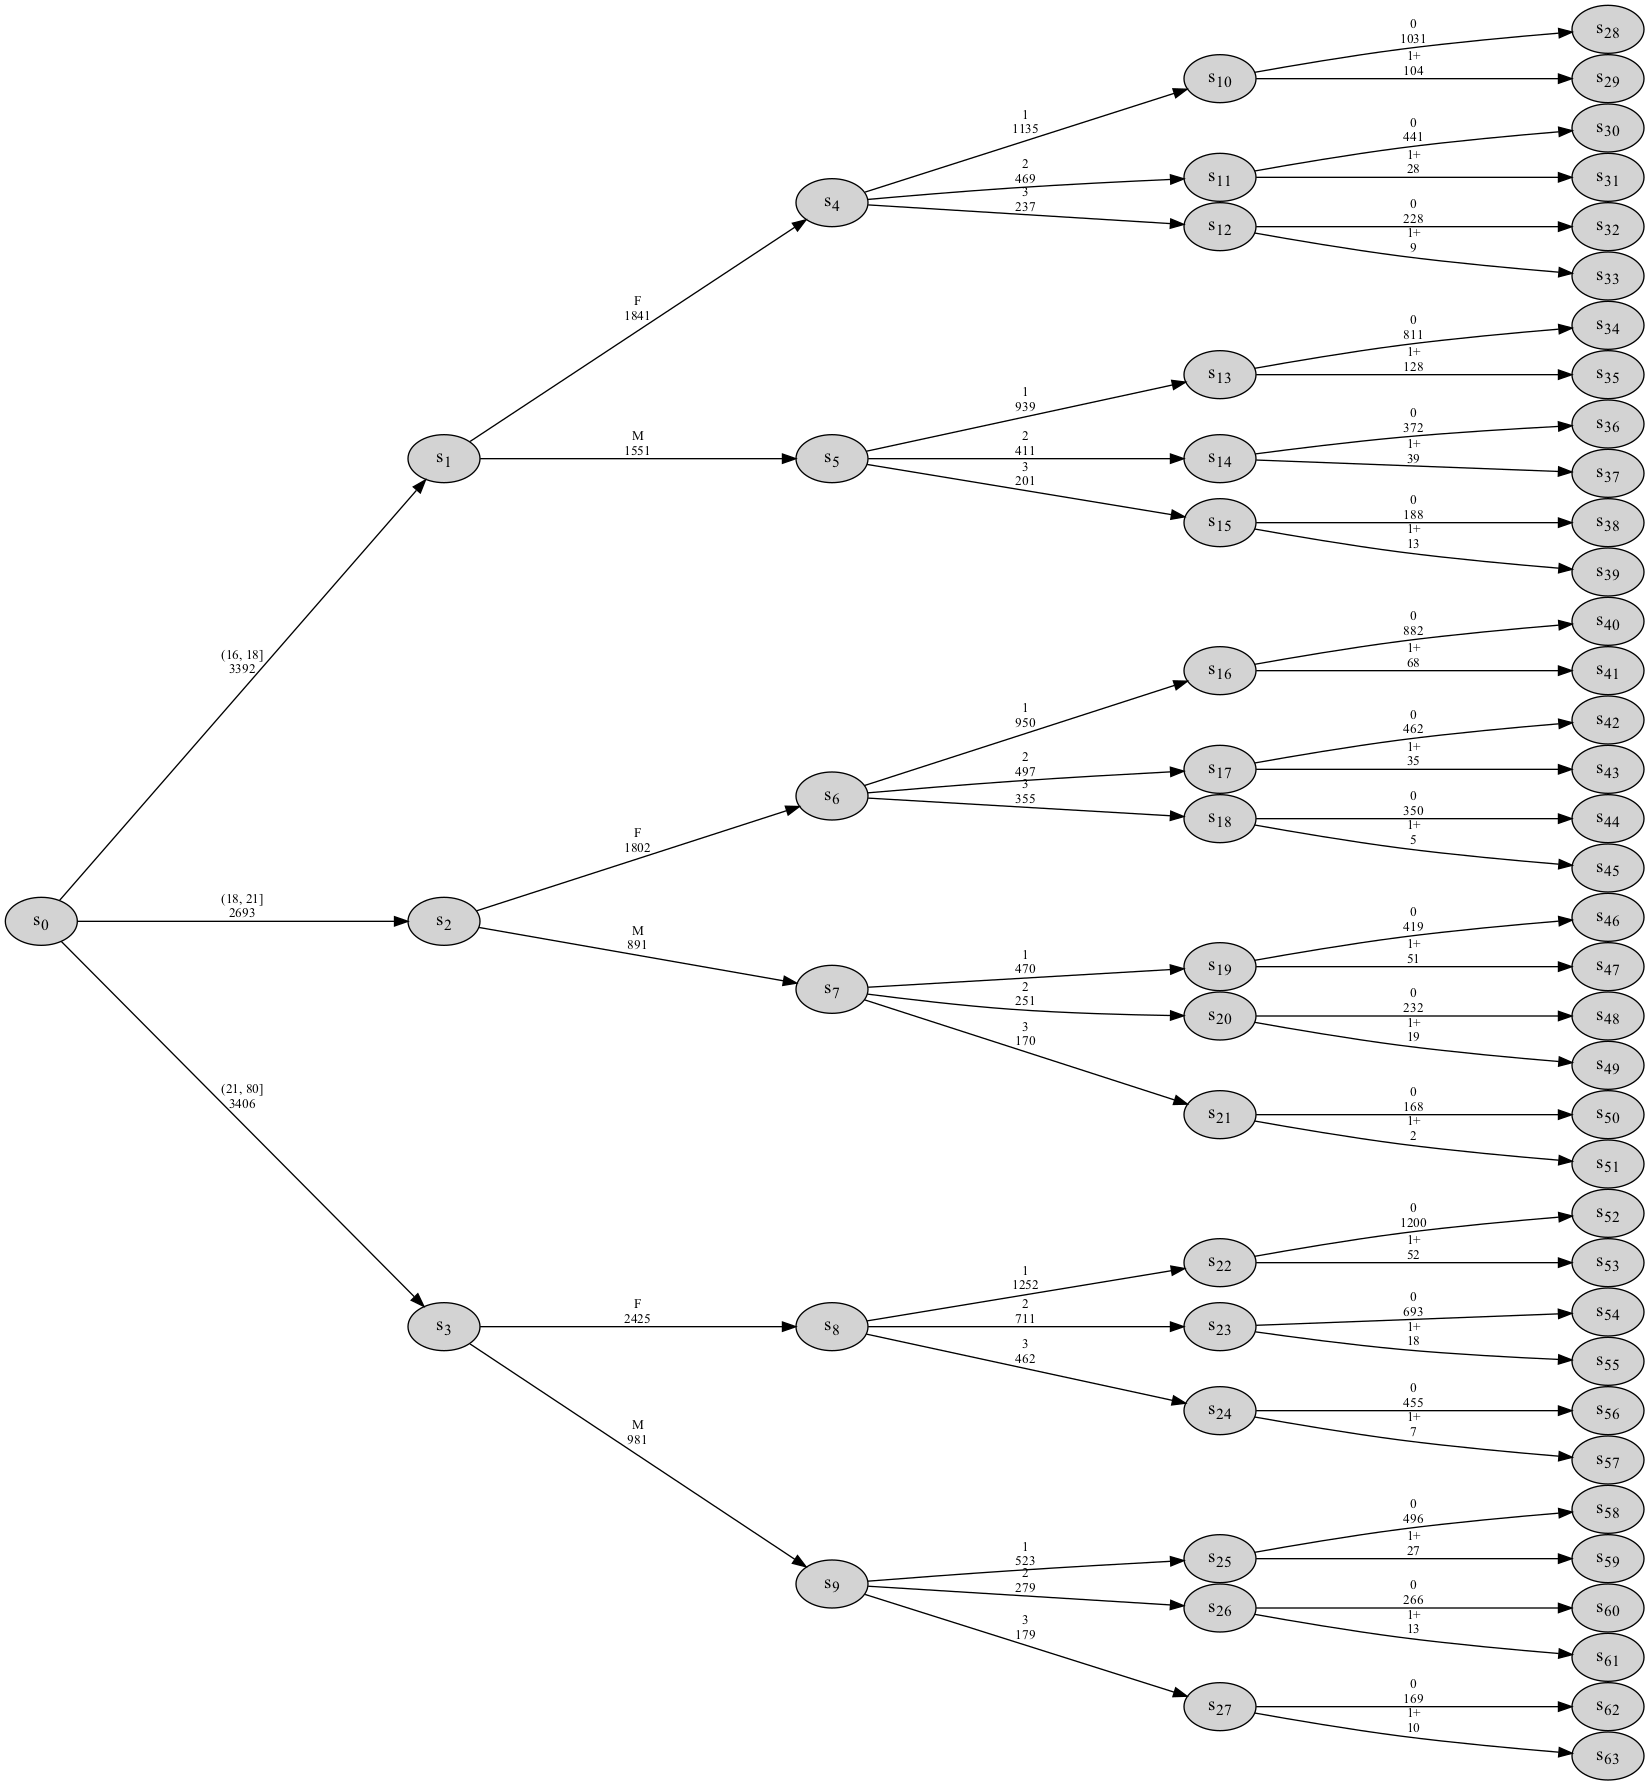

In [8]:
var_order = ['age_group', 'sex', 'freq', 'acc_inv']
freq_et = cegpy.EventTree(df, var_order=var_order)

display_graph(freq_et.dot_event_graph())

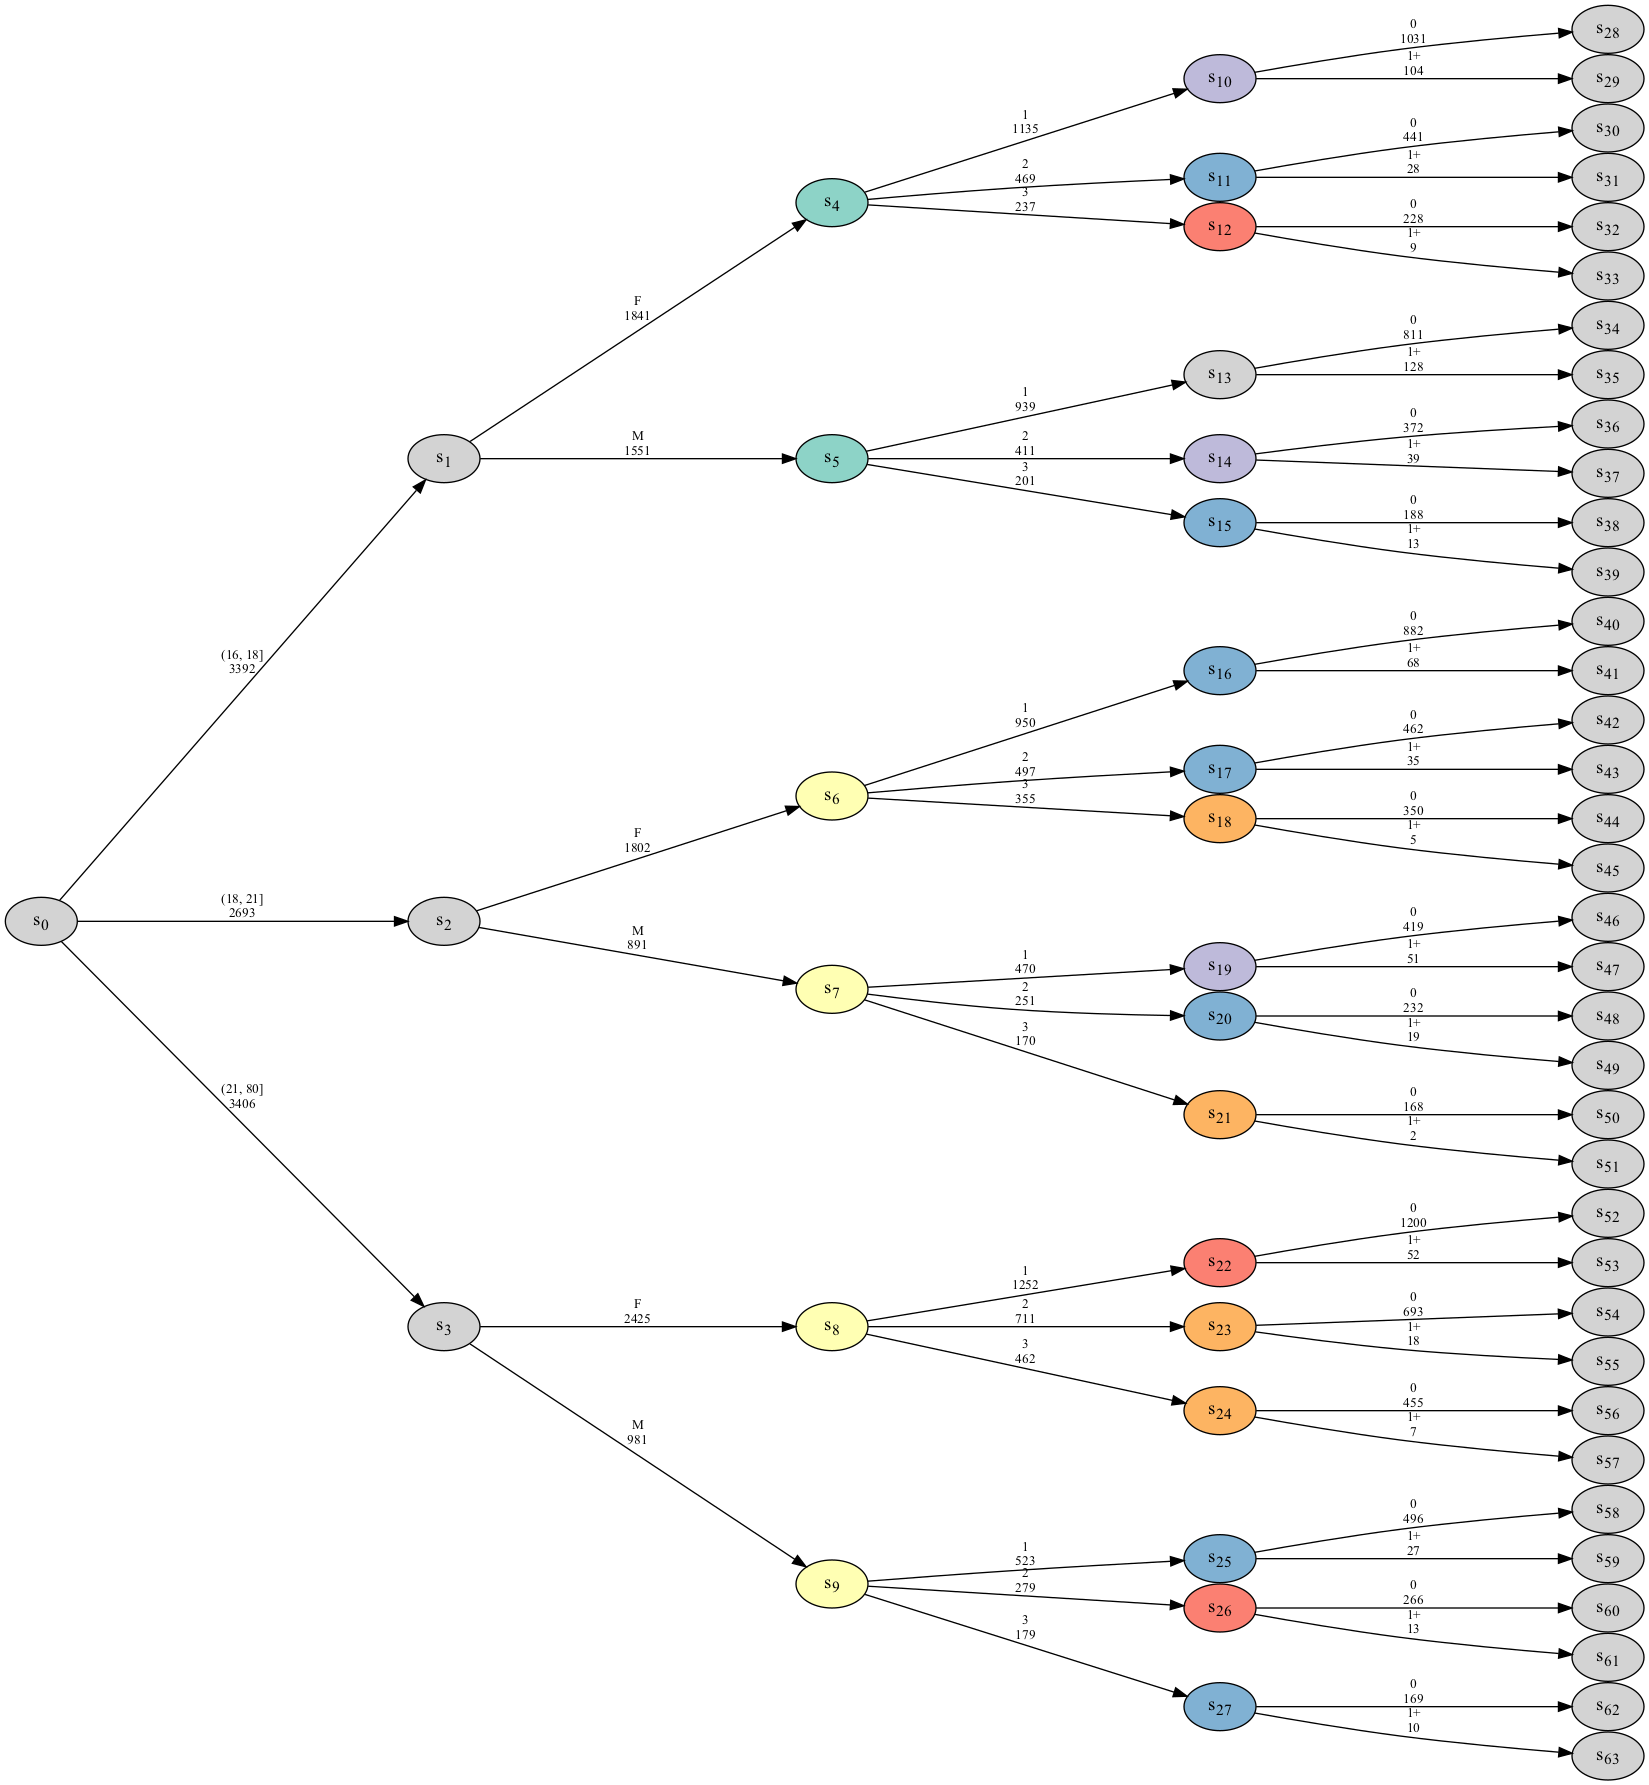

In [9]:
freq_st = cegpy.StagedTree(df, var_order=var_order)
freq_st.calculate_AHC_transitions(colour_list=colours)

display_graph(freq_st.dot_staged_graph())

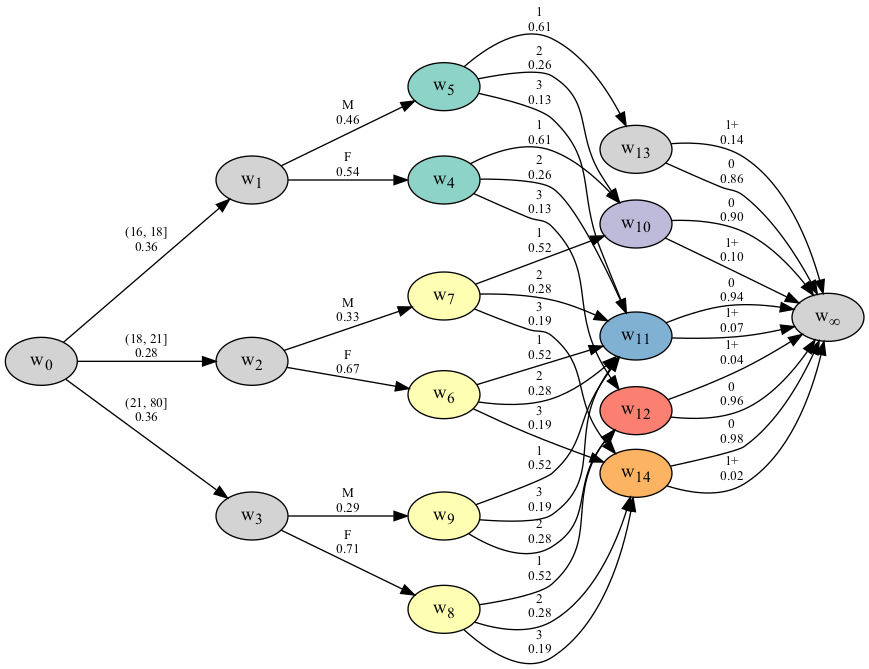

In [10]:
ceg = cegpy.ChainEventGraph(freq_st)

display_graph(ceg.dot_graph(), ranksep=1)

Conclusion which are the same based on the BN:
- Gender ratio depends on the age group (positions $w_1$, $w_2$, $w_3$ are in different stages)
- The frequency of driving is dependent on the age group (positions $w_5, \ldots, w_8$ are in different stages)
- The frequency of driving is independent of sex, given the age group (edges corresponding to men and women emanting from positions $w_1$, $w_2$, $w_3$, lead to positions of the same colour).



New insights:
- Gender inbalance is the smallest for the youngest age group (16, 18]
- Given the age group, according to the BN, the accident involvement depends only on the frequency. The CEG tells us something, else.
  For all positions $w_5, \ldots, w_8$ the edges corrsponding to the same frequency of driving for men and women do **not** lead to the same positions on the accident-involement level. We can scrutinize this one by one for each driving frequency level by looking at the subgraphs of the CEG.
 

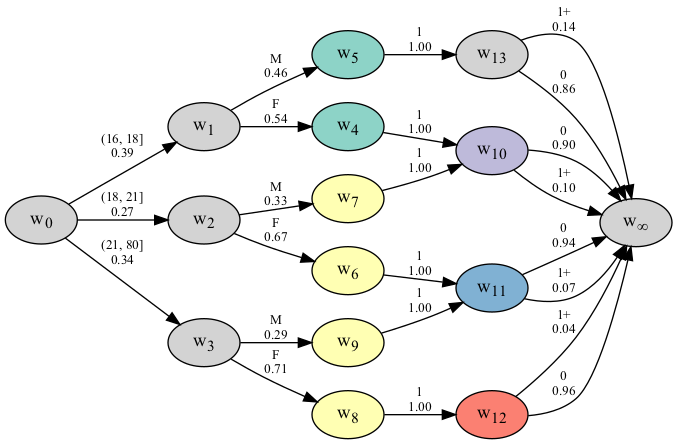

In [11]:
# Daily driving subgraph

reduced_ceg = cegpy.ChainEventGraphReducer(ceg)
reduced_ceg.add_uncertain_edge_set([
    ('w5', 'w13', '1'),
    ('w4', 'w10', '1'),
    ('w7', 'w10', '1'),
    ('w6', 'w11', '1'),
    ('w9', 'w11', '1'),
    ('w8', 'w12', '1'),
])
reduced_ceg.graph.create_figure()

E.g.  
- (16, 18] women driving everyday end up in position $w_{10}$ (0.1% prob of an accident)
- (16, 18] men driving everyday end up in position $w_{13}$ (0.14 % prob of an accident). 


### The ordinal CEG
The above is an example of an **ordinal** CEG.  It gives an easily interpretable graphical representation of the standard CEG by imposing a particular ordering on the positions of the graph. An ordinal CEG with respect to a binary variable $Y$ is a CEG where positions in each vertex subset associated with a variable $X_i$, are vertically aligned in order with respect to the predictive probability $\mathbb{P}(Y = 1 | X_i)$.

Currently there is no implementation of the ordinal CEG in the `cegpy` package.  The deafult node allignemnt in this case just happens to coincide with the ordinal CEG :).

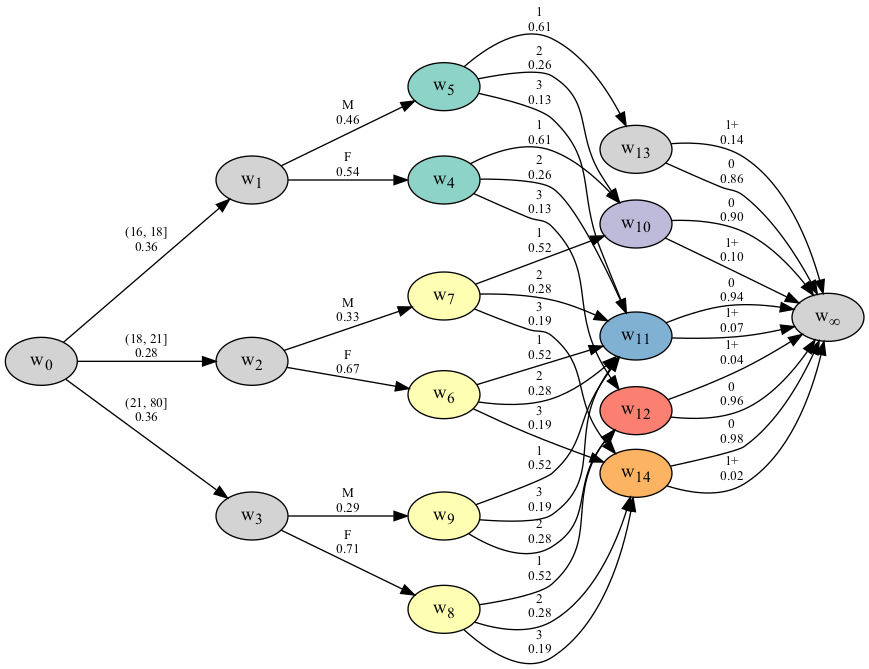

In [12]:
ceg = cegpy.ChainEventGraph(freq_st)

display_graph(ceg.dot_graph(), ranksep=1)

We can immediatelly say that:
- **younger** drivers are associated with a higher rate accidents
- **men** are more likely to be involved in an accident than women
- **higher frequency** of driving leads to a higher likelihood of an accident

## Part 2: Dealing with missing data

**Missing Completely At Random:**
The observations with missing values are just a random subset of the entire data set (MCAR).

**Missing At Random:**
The probability of being missing is the same within groups defined by the observed data (MAR), i.e. it can be predicted from the remaining observations.

**Missing Not At Random:**
Neither MCAR nor MAR holds. Missingness is related to what is actually missing.

In [13]:
df.isna().sum()

age            0
sex            0
freq           0
miles        757
acc_inv        0
age_group      0
mileage      757
dtype: int64

In our example, the mileage has some missing values. Let's use CEG's to find out about the nature of the missingness. We introduce a new variable:
$R_{miles}$ - an indicator wether the miles response is missing or not. We first consider some hypothetical scenerios.

In order to learn about the nature of the missingness in our data set, we add a new variable $R_{miles}$ which indicates whether the response to the question about the mileage is missing or not.

First, let's us look at some simulated examples.

### Completely random missingness

- For a 757 random rows set $R_{miles} = \text{missing}$.

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Filter edges based on black_list/white_list


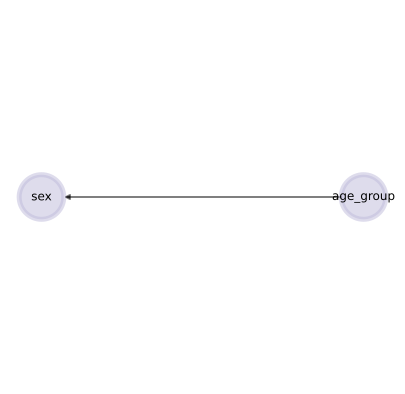

In [14]:
df['is_missing'] = 'not_missing'
df.loc[df.sample(757).index, 'is_missing'] = 'missing'
var_order = ['age_group', 'sex', 'is_missing']

# a BN representation
fit_and_plot_bn(df, ['age_group', 'sex', 'is_missing'])

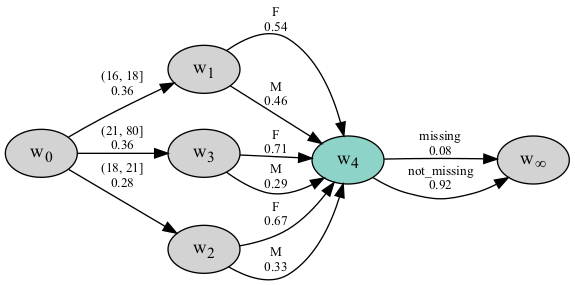

In [15]:
# a CEG representation
missing_st = cegpy.StagedTree(df, var_order=var_order)
missing_st.calculate_AHC_transitions(colour_list=colours)
ceg = cegpy.ChainEventGraph(missing_st)
ceg.create_figure()

### Missing response dependent on age only

- For 10% of randomly selected rows in the $(16, 18] \cup (21, 80]$ age group set $R_{miles} = \text{missing}$.
- For 5% of randomly selected rows in the $(18, 21]$ age group set $R_{miles} = \text{missing}$.

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Filter edges based on black_list/white_list


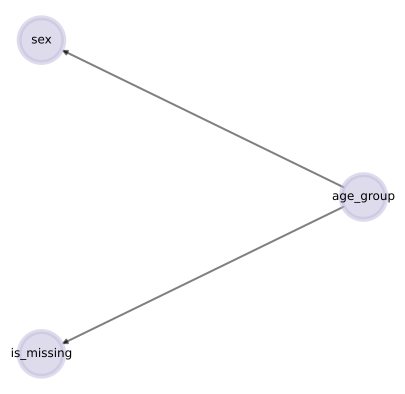

In [16]:
df['is_missing'] = 'not_missing'
df.loc[df[(df.age <= 18) | (df.age > 21)].sample(
        frac=0.1).index, 'is_missing'] = 'missing'
df.loc[df[
    (df.age > 18) & (df.age <= 21)].sample(
    frac=0.05).index, 'is_missing'] = 'missing'

# a BN representation
fit_and_plot_bn(df, ['age_group', 'sex', 'is_missing'])

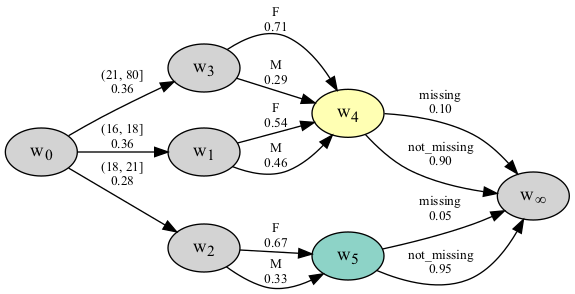

In [17]:
# a CEG representation
var_order = ['age_group', 'sex', 'is_missing']
missing_st = cegpy.StagedTree(df, var_order=var_order)
missing_st.calculate_AHC_transitions(colour_list=colours)
ceg = cegpy.ChainEventGraph(missing_st)
ceg.create_figure()

### Missing response dependent on sex only

- For 10% of randomly selected rows among women set $R_{miles} = \text{missing}$.
- For 50% of randomly selected rows among men set $R_{miles} = \text{missing}$.

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Filter edges based on black_list/white_list


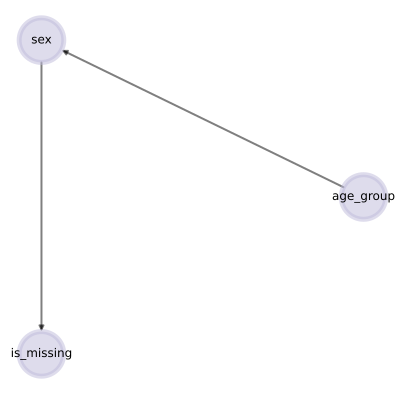

In [18]:
df['is_missing'] = 'not_missing'
df.loc[df[df.sex == 'F'].sample(frac=0.1).index, 'is_missing'] = 'missing'
df.loc[df[df.sex == 'M'].sample(frac=0.5).index, 'is_missing'] = 'missing'

# a BN representation
fit_and_plot_bn(df, ['age_group', 'sex', 'is_missing'])

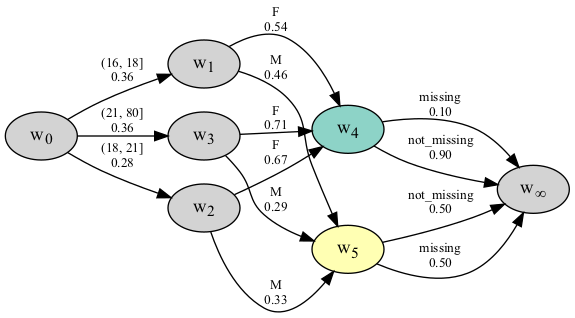

In [19]:
# a CEG representation
missing_st = cegpy.StagedTree(df, var_order=var_order)
missing_st.calculate_AHC_transitions(colour_list=colours)
ceg = cegpy.ChainEventGraph(missing_st)
ceg.create_figure()

### What is truly in the data?
- Set $R_{miles}$ according to the actual data.

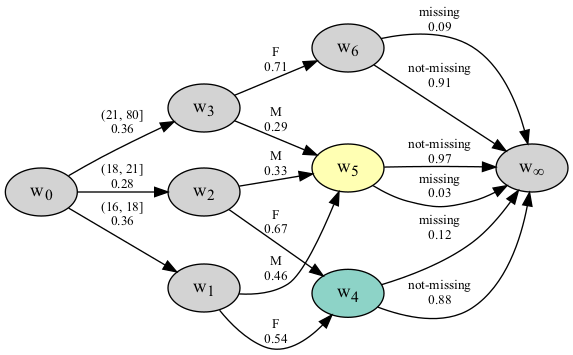

In [20]:
df['is_missing'] = df['mileage'].isna().map({
    True: 'missing', False: 'not-missing'})
var_order = ['age_group', 'sex', 'is_missing']

# a CEG representation
missing_st = cegpy.StagedTree(df, var_order=var_order)
missing_st.calculate_AHC_transitions(colour_list=colours)
ceg = cegpy.ChainEventGraph(missing_st)
ceg.create_figure()

Clearly data are not MCAR. However, observe that all men end up in the same position $w_5$. We can say that the data are conditionally MCAR. I.e. given that $X_{sex} = M$ we have that the missingness of the mileage response is independent of age:

$$R_{miles} \perp X_{age} \ | \ X_{sex} = M$$

Is a BN able to tell us the same?

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Filter edges based on black_list/white_list


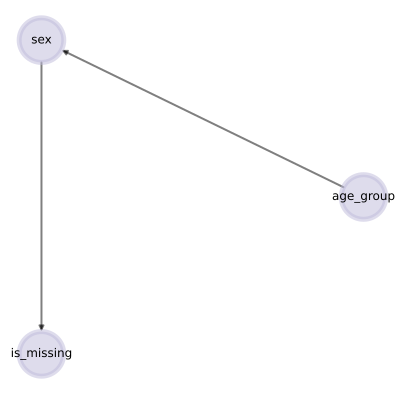

In [21]:
fit_and_plot_bn(df, ['age_group', 'sex', 'is_missing'])

### A CEG on $\boldsymbol{X} = \left(X_{age}, X_{sex}, R_{miles}, X_{miles}, Y\right)$

We now create the entire CEG involving all 5 variables.

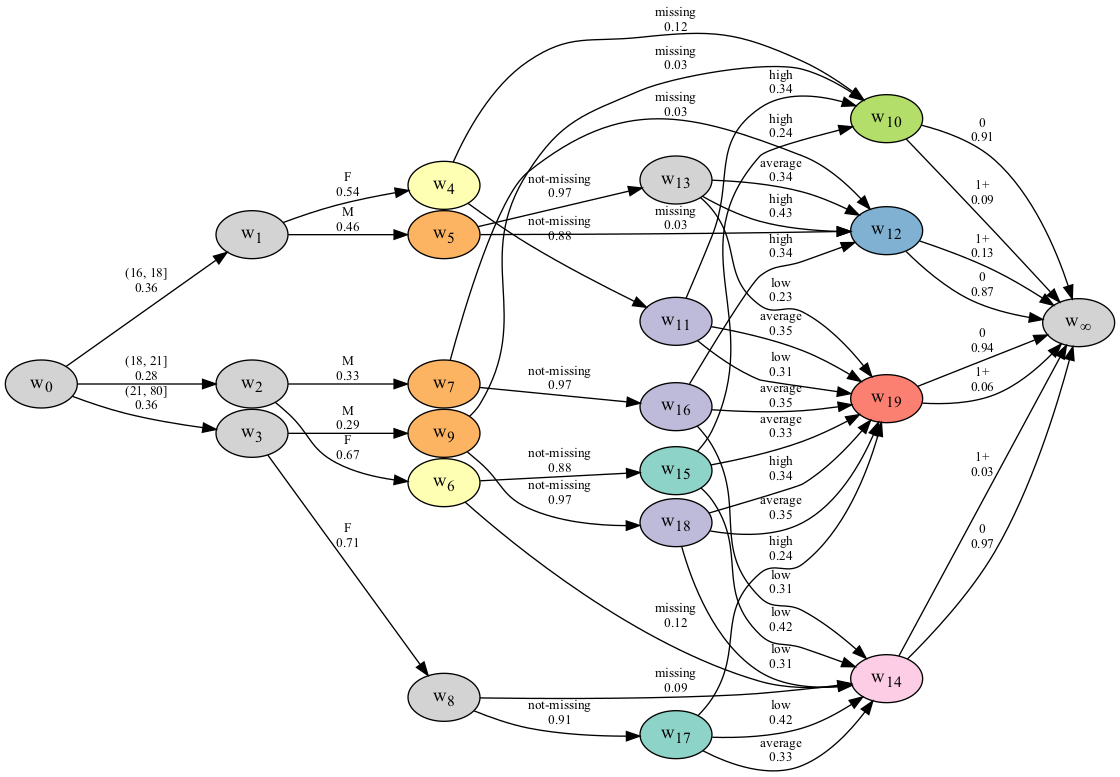

In [22]:
df['is_missing'] = df['mileage'].isna().map({True: 'missing', False: 'not-missing'})
var_order = ['age_group', 'sex', 'is_missing', 'mileage', 'acc_inv']

missing_st = cegpy.StagedTree(df, var_order=var_order)
missing_st.calculate_AHC_transitions(colour_list=colours)
ceg = cegpy.ChainEventGraph(missing_st)

display_graph(ceg.dot_graph(), ranksep=1)

This is a little bit hard to wrap your head around. Sometimes, it is easier to look at subgraphs of a CEG, instead of the entitre graph at once.

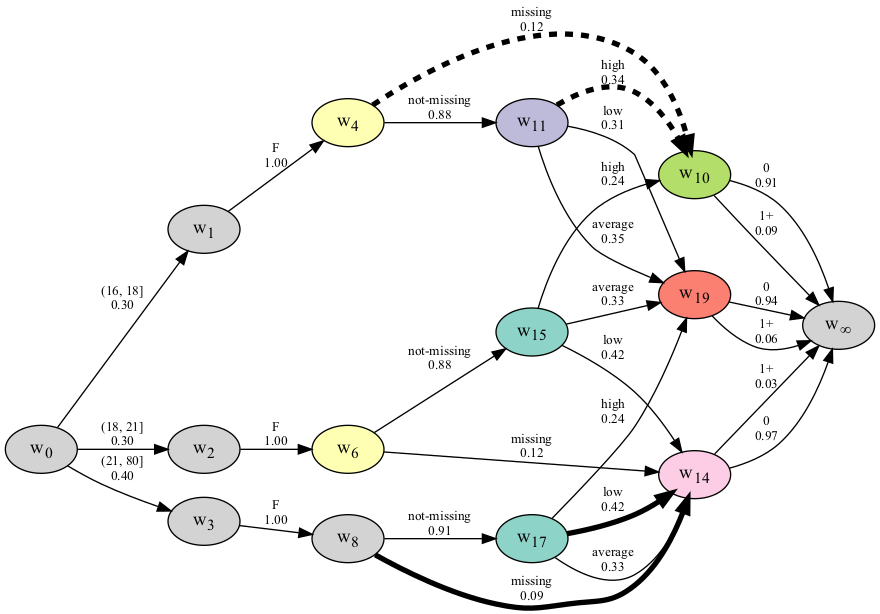

In [23]:
# All women subgraph
ceg_reduced = cegpy.ChainEventGraphReducer(ceg)
ceg_reduced.add_uncertain_edge_set([
    ('w2', 'w6', 'F'),
    ('w3', 'w8', 'F'),
    ('w1', 'w4', 'F')
])

g = ceg_reduced.graph.dot_graph()
edges = [
  ('w8', 'w14'), ('w17', 'w14')
]
for e in edges:
    g.get_edge(e)[-1].set_penwidth(4)
    
edges = [
    ('w4', 'w10'), ('w11', 'w10')
]
for e in edges:
    g.get_edge(e)[-1].set_penwidth(4)
    g.get_edge(e)[-1].set_style('dashed')
    
Image(g.create_png())

We observe that for older women aged 21+, the missing mileage coincides with the position of the average mileage. While for the youngest, it coincides with the highest mileage.

Under the assumption of MAR, the edge labelled $missing$ emanating from the nodes on the $R_{miles}$ level should lead to stages whose predictive probability of an accident is close to the weighted average of the predictive probabilities of accident involvement when the mileage is known (low, average or high). 
A quick calculation shows this isn't the case. Is missingness informative?

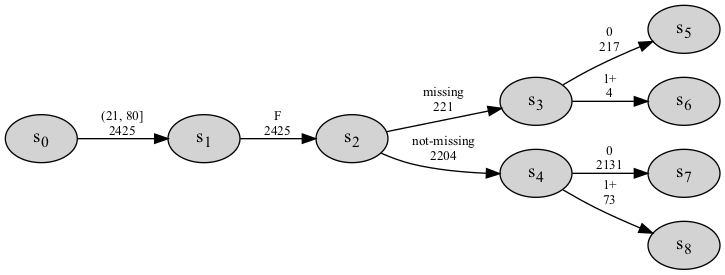

In [24]:
# the oldest
miss_et = cegpy.EventTree(
    df[(df.sex == 'F') & (df.age > 21)], 
    var_order=['age_group', 'sex', 'is_missing', 'acc_inv']
)
miss_et.create_figure()

In [25]:
# accident probability when missing
4 / 221

0.01809954751131222

In [26]:
# accident probability when not missing 
73 / 2204

0.03312159709618875

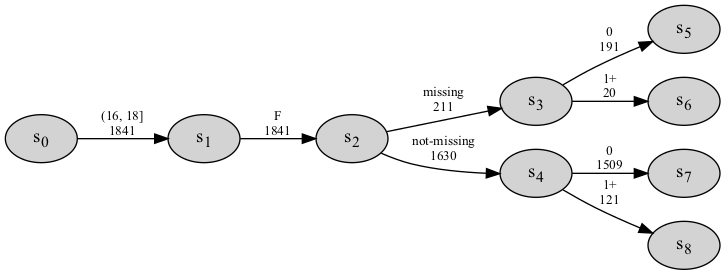

In [27]:
# the youngest
miss_et = cegpy.EventTree(
    df[(df.sex == 'F') & (df.age <= 18)], 
    var_order=['age_group', 'sex', 'is_missing', 'acc_inv']
)
miss_et.create_figure()

In [28]:
# accident probability when missing
20 / 211

0.0947867298578199

In [29]:
# accident probability when not missing
121 / 1630

0.07423312883435583

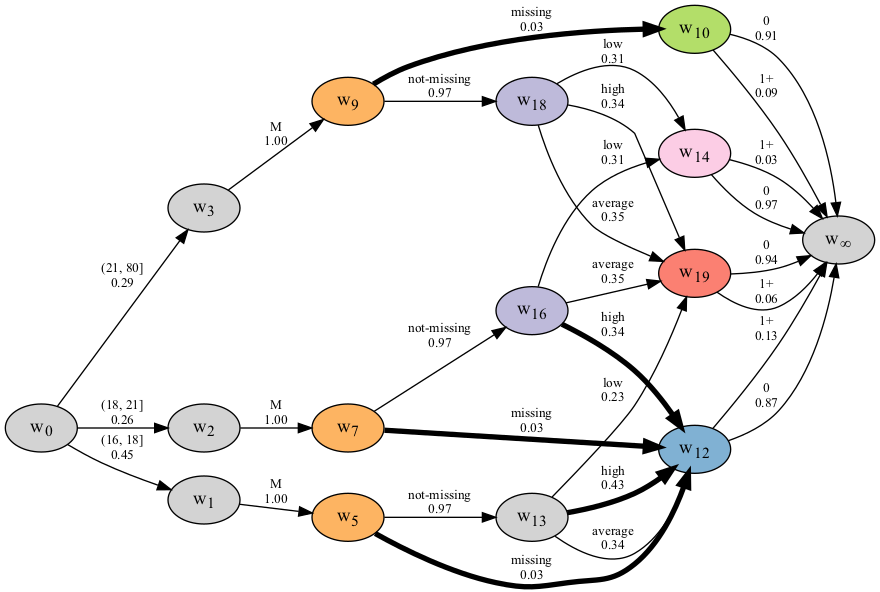

In [30]:
# all man sub-graph
ceg_reduced = cegpy.ChainEventGraphReducer(ceg)
ceg_reduced.add_uncertain_edge_set([
    ('w3', 'w9', 'M'),
    ('w2', 'w7', 'M'),
    ('w1', 'w5', 'M')
])

g = ceg_reduced.graph.dot_graph()

edges = [
    ('w5', 'w12'), ('w13', 'w12'), ('w7', 'w12'), ('w16', 'w12'),
    ('w9', 'w10')
]
for e in edges:
    g.get_edge(e)[-1].set_penwidth(4)
    
Image(g.create_png())

We could repeat the same for men. We find that for men, missingness coincides with the highest mileage. Yet, the sample size for male respondents might be too small to make any sound judgements.

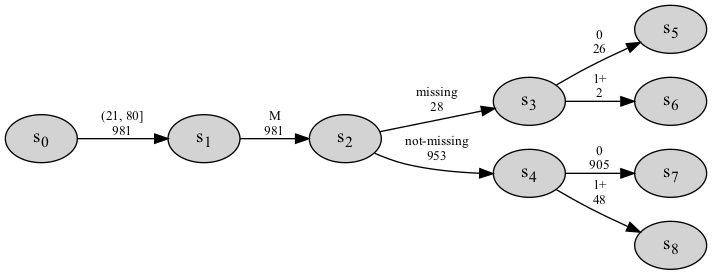

In [31]:
# the oldest man
miss_et = cegpy.EventTree(
    df[(df.sex == 'M') & (df.age > 21)], 
    var_order=['age_group', 'sex', 'is_missing', 'acc_inv']
)
miss_et.create_figure()

In [32]:
# accident probability when missing
2 / 28

0.07142857142857142

In [33]:
# accident probability when not missing
48 / 953

0.05036726128016789

## Part 3: Modelling the non-reponse - a non-stratified CEG

One major obstacle to treat the ‘Cohort II’ as a longitudinal study is the dropping response rate within subsequent waves of the Driving Experience Questionnaire. In this section, we apply Chain Event Graphs to look at the patterns of non-response to the subsequent waves of the survey. We let $X_{sex}$ to be the variable describing the gender of a respondent and $X_1,X_2,X_3,X_4$ four binary variables indicating the response to surveys DEQ1, DEQ2, DEQ3 and DEQ4 respectively.

<center><img src="img/flowchart.png" width="500"/></center>

In [41]:
df = pd.read_csv('data/new_missing_values.csv', index_col=0)
df = df[df.sent == 1]
df[['wave1', 'wave2', 'wave3', 'wave4']] = df[[
   'wave1', 'wave2', 'wave3', 'wave4']].astype('float32').apply(
    lambda x: x.map({1.0: 'yes', 0.0: 'no'}))
df.head()

,sex,cohort,sent,wave1,wave2,wave3,wave4
24,F,2,1,yes,yes,yes,yes
25,M,15,1,yes,yes,NaN,NaN
41,F,5,1,no,no,no,no
51,M,3,1,no,yes,yes,yes
54,M,4,1,yes,no,yes,yes


In this example we are dealing with a non-stratified CEG, i.e. the AHC when creating the stages will not be restricted to a single variable only. Let's start with some hypothetical examples.

### Responses dependent on sex, independent of the previous responses

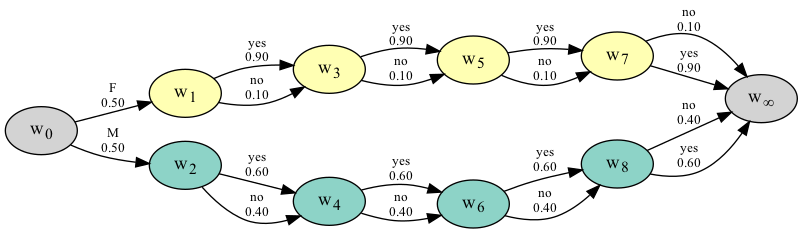

In [42]:
fake_df = pd.DataFrame(index=list(range(0, 200000)))
fake_df['sex'] = 'M'
fake_df.loc[0:100000, 'sex'] = 'F'
fake_df[
    ['wave1', 'wave2', 'wave3', 'wave4']
] = ['yes', 'yes', 'yes', 'yes']
for i in range(1, 5):
    fake_df.loc[fake_df[
        fake_df.sex == 'M'].sample(frac=0.4).index, f'wave{i}'] = 'no'
    fake_df.loc[fake_df[
        fake_df.sex == 'F'].sample(frac=0.1).index, f'wave{i}'] = 'no'
    
response_st = cegpy.StagedTree(
    fake_df, var_order=['sex', 'wave1', 'wave2', 'wave3', 'wave4'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

### Responses dependent on the wave number and sex, independent of the previous responses

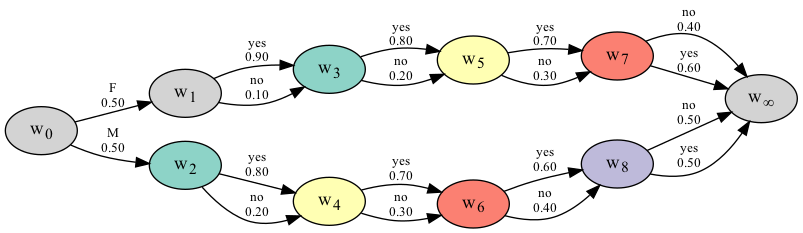

In [43]:
fake_df = pd.DataFrame(index=list(range(0, 200000)))
fake_df['sex'] = 'M'
fake_df.loc[0:100000, 'sex'] = 'F'
fake_df[
    ['wave1', 'wave2', 'wave3', 'wave4']
] = ['yes', 'yes', 'yes', 'yes']
for i in range(1, 5):
    fake_df.loc[fake_df[
        fake_df.sex == 'M'].sample(frac=0.1 * (i + 1)).index, f'wave{i}'] = 'no'
    fake_df.loc[fake_df[
        fake_df.sex == 'F'].sample(frac=0.1 * i).index, f'wave{i}'] = 'no'
    
response_st = cegpy.StagedTree(
    fake_df, var_order=['sex', 'wave1', 'wave2', 'wave3', 'wave4'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

### The data

Instead of creating the entire CEG at once, we add the next variables one by one.

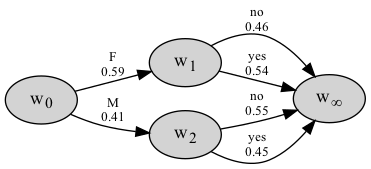

In [44]:
response_st = cegpy.StagedTree(df, var_order=['sex', 'wave1'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

The response to the first survey is dependent on sex. Women are more likelly to respond.

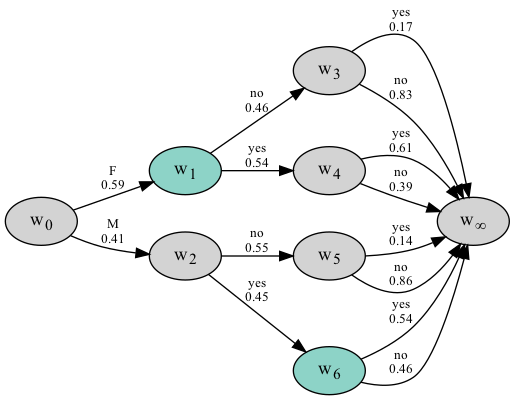

In [45]:
response_st = cegpy.StagedTree(
    df, var_order=['sex', 'wave1', 'wave2'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

The response to the second survey is dependent on both the sex and the response to the previous survey. A person who respondent to the first survey is more likely to respond to the second one.

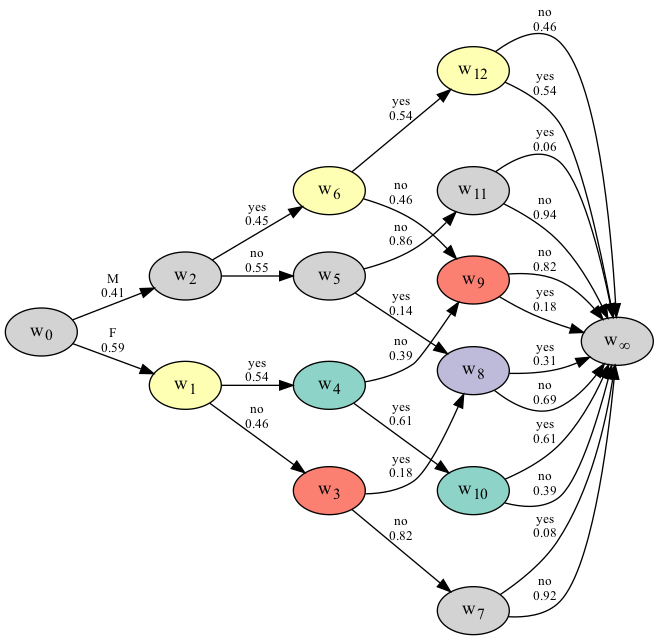

In [46]:
response_st = cegpy.StagedTree(
    df, var_order=['sex', 'wave1', 'wave2', 'wave3'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

If a person responded to only one of the first two surveys, their likelihood of response to the third survey is independent of sex. The paths following the edges $no-yes$ and $yes-no$ for women and men end up in the same positions ($w_9$ and $w_8$).

As a modification to the CEG, we can try to merge the first two variables into one, which does simplify the graph.

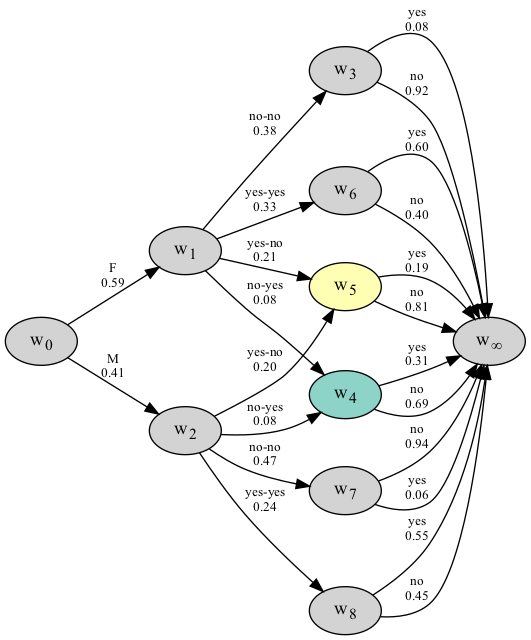

In [47]:
df['wave12'] = df['wave1'] + '-' + df['wave2']
response_st = cegpy.StagedTree(
    df, var_order=['sex', 'wave12', 'wave3'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

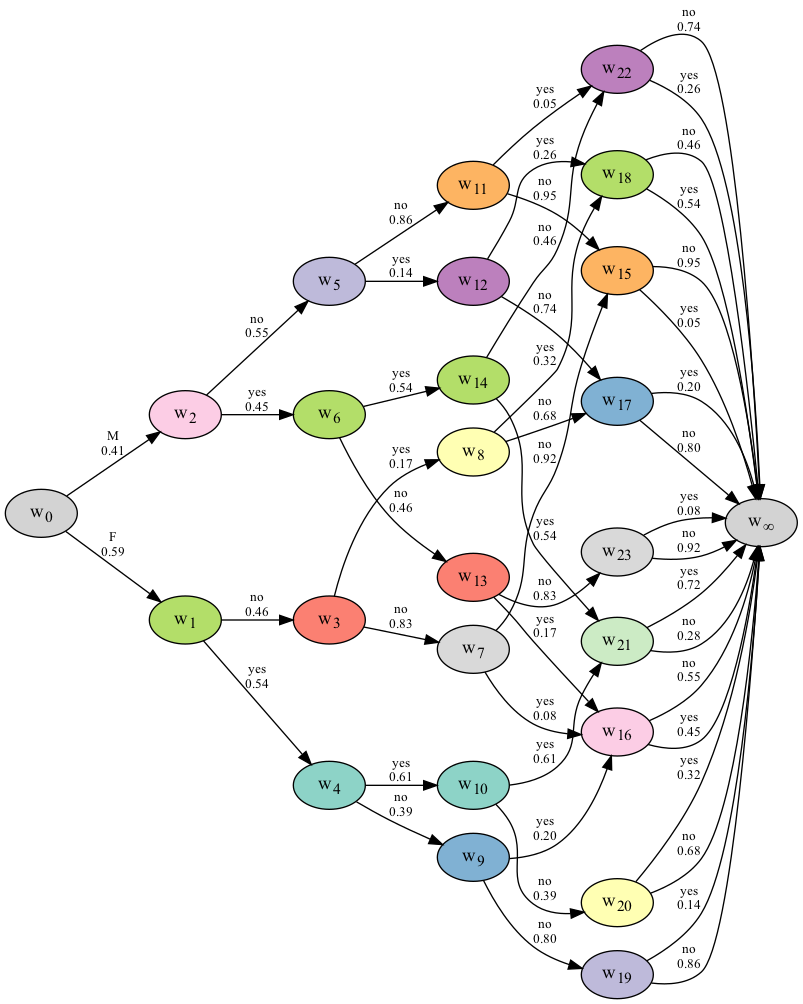

In [48]:
response_st = cegpy.StagedTree(
    df, var_order=['sex', 'wave1', 'wave2', 'wave3', 'wave4'])
response_st.calculate_AHC_transitions(colour_list=colours)
response_ceg = cegpy.ChainEventGraph(response_st)
response_ceg.create_figure()

Adding the fourth variable, makes the picture very hard to understand. Yet, we can still try to identify some patterns:

- By following the root to sink paths we can observe how the probability of responding to the next survey increases (or decreases) when the response to the previous survey was (or wasn't) recorded.

- In the last level we have 9, distinct positions. To each of the positions $w_{15}, w_{17}, w_{18}, w_{21}$, lead exactly two paths, having the same patterns of response for both men and women. Hence, after observing patterns $\text{yes-yes-yes}$, $\text{no-yes-yes}$, $\text{no-yes-no}$,  or $\text{no-no-no}$, the probability of the response to the final survey is independent of sex. 

Let's have a look at the reduced CEG which focuses on situations $w_{15}, w_{17}, w_{18}, w_{21}$ only.

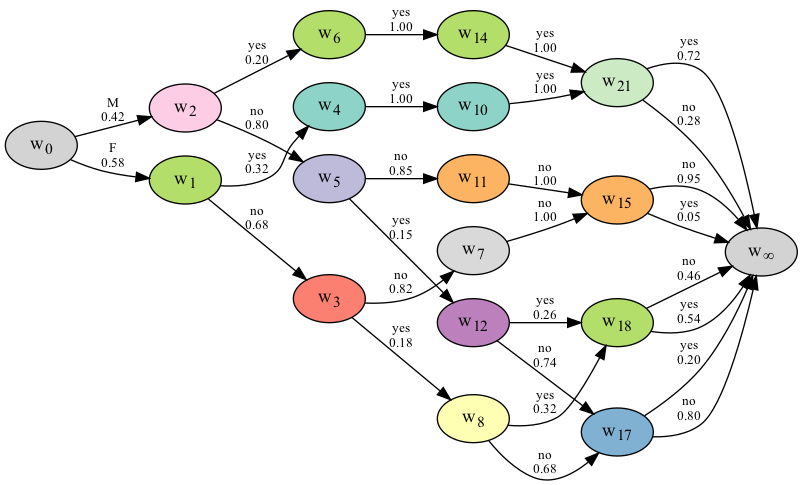

In [49]:
ceg_reduced = cegpy.ChainEventGraphReducer(response_ceg)
ceg_reduced.add_uncertain_node_set([
    'w15', 'w17', 'w18', 'w21'
])
ceg_reduced.graph.create_figure()

And on the remaining situations

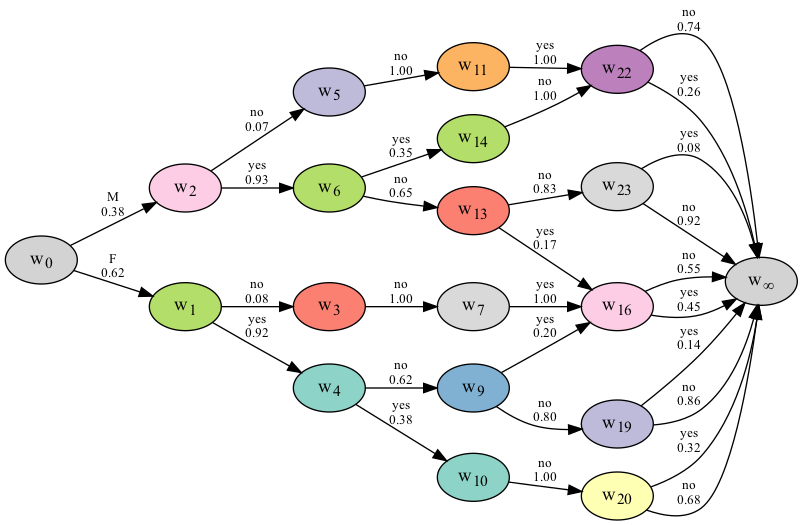

In [50]:
ceg_reduced.clear_all_evidence()
ceg_reduced.add_uncertain_node_set([
    'w16', 'w19', 'w20', 'w22', 'w23'
])
ceg_reduced.graph.create_figure()